# Neural & Behavioral Modeling - Week 5 (Examples)
by Tsung-Ren (Tren) Huang (tren.huang@gmail.com)

In [2]:
%config IPCompleter.greedy=True 
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from IPython.display import *
import pandas as pd
import scipy.optimize as opt

## 1 Human Development
Schöner, G., & Thelen, E. (2006). Using dynamic field theory to rethink infant habituation. Psychological Review, 113(2), 273.

### 1.0 Fig. 2

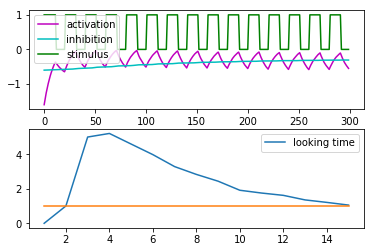

In [4]:
def stimulus(x):
    return 1 if (x%20 <= 10) else 0

def delta(x):
    return 1/(1 + exp(-beta*x))

tu = 10
tv = 200
hu = -.8
hv = -.4
cu = 2
cv = 2
beta = 10
qu = 0.025
qv = 0.005
u = [-1.6]
v = [-.6]
s = [stimulus(0)]
t = arange(0, 300, 1)
integration, integration1 = [0], 0
count = arange(1, 16, 1)

for i in t:
    noise = np.random.normal(0,1,2)
    u1, v1 , s1 = u[-1], v[-1], s[-1]
    u1 += (-u1 + hu + stimulus(i) - cu*delta(v1) + qu*noise[0])/tu
    v1 += (-v1 + hv + cv*delta(u1) + qv*noise[1])/tv
    s1 = stimulus(i)
    u.append(u1)
    v.append(v1)
    s.append(s1)

for c in count:
    integration1 = 0
    for i in range( ((c-1)*20) , (c*20) ):
        if u[i] >= v[i]:
            integration1 += u[i] - v[i]
    integration.append(integration1)

baseline = [(integration[0] + integration[1] + integration[2])/6]*16

subplot(211)
plot(t, u[0:-1], 'm-')
plot(t, v[0:-1], 'c-')
plot(t, s[0:-1], 'g-')
legend(['activation', 'inhibition', 'stimulus'])

subplot(212)
plot(count, integration[0:-1])
plot(count, baseline[0:-1])
legend(['looking time']);

## 2 Instructed Learning
Walsh, M. M., & Anderson, J. R. (2011). Modulation of the feedback-related negativity by instruction and experience. Proceedings of the National Academy of Sciences, U.S.A., 108, 19048–1905.

### 2.1 Data Generation
Because we don't have the experiment data, we have to generate the data by ourselves according to the paper:
> Three cues reward with different probability (P = {0%, 33%, 66%}). Two cues appeared in each tiral, creating three pairs (66/33, 66/0, 33/0; order does't matter). The experiment run four epochs of 120 trials.

In other words, this experiment has a total of 120 trials. Each cue pair (66/33, 66/0, 33/0) consists of 40 trials. A resesarch participants chooses one of the cues, gets feedback accordingly, and updates his/her perceived value about the cue via reinforcement learning.

#### 2.1.1 Data under no instruction (NI_)

,Cue0,Cue1,Response,Feedback0,Feedback1
0,66.0,33.0,1.0,1.0,0.0
1,33.0,0.0,0.0,1.0,0.0
2,66.0,33.0,1.0,0.0,1.0
3,66.0,33.0,1.0,1.0,0.0
4,66.0,33.0,1.0,0.0,1.0


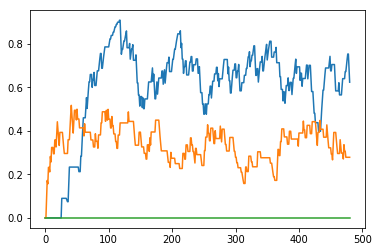

In [13]:
# Create the structure of experiments
## How many trials?
t_n = 480

## Cue pairs (CP, A:(66/33), B:(66/0), C:(33/0))
## CP = np.repeat(np.array([1,2,3]), 40)
NI_CP = np.repeat(np.array([[66,33], [66,0], [33,0]]), (t_n/3), axis = 0)
np.random.shuffle(NI_CP) # shuffle the sequence

## Feedback (1 = win, 0 = lose)
NI_FB = (np.random.rand(t_n, 2) < NI_CP*0.01)*1

## Action vector: the response made by subjects
NI_AV = np.empty([t_n,1])
NI_AV[:] = np.nan
Q66 = np.empty([(t_n+1),1])
Q66[:] = np.nan
Q33 = np.empty([(t_n+1),1])
Q33[:] = np.nan
Q00 = np.empty([(t_n+1),1])
Q00[:] = np.nan 

# setting parameter
## free parameters
alpha = 0.09
tau = 0.17
beta = 0.00  # don't need in no instruction
gamma = 0.00 # don't need in no instruction

## Utility of cues (start from 0 if no instruction)
Q66[0] = 0
Q33[0] = 0
Q00[0] = 0

# define a reinforcement function
for t in np.arange(0, len(NI_CP)):
    
    # Assign utility of first cue
    Cue_0 = NI_CP[t][0]
    if np.isclose(Cue_0, 66):
        Qcur_0 = Q66[t]
    elif np.isclose(Cue_0, 33):
        Qcur_0 = Q33[t]
    else:
        Qcur_0 = Q00[t]
    
    # Assign utility of second cue
    Cue_1 = NI_CP[t][1]
    if np.isclose(Cue_1, 66):
        Qcur_1 = Q66[t]
    elif np.isclose(Cue_1, 33):
        Qcur_1 = Q33[t]
    else:
        Qcur_1 = Q00[t]

    # Caculate probaility of choose first cue
    Prob_0 = (np.exp(Qcur_0/tau))/(np.exp(Qcur_0/tau) + np.exp(Qcur_1/tau))
    
    # Add some noise
    Prob_0 = Prob_0 + np.random.normal(0,0.5,1)
    
    # Action
    if Prob_0 > 0.5:
        NI_AV[t] = 0
    elif Prob_0 < 0.5:
        NI_AV[t] = 1
    else:
        NI_AV[t] = np.round(np.random.rand(1))
    
    # See the feedback and update utility of cue with RPE
    if np.isclose(NI_AV[t], 0):
        RPE = NI_FB[t][0] - Qcur_0
        if np.isclose(Cue_0, 66):
            Q66[t+1] = Qcur_0 + alpha * RPE
        elif np.isclose(Cue_0, 33):
            Q33[t+1] = Qcur_0 + alpha * RPE
        else:
            Q00[t+1] = Qcur_0 + alpha * RPE
    else:
        RPE = NI_FB[t][1] - Qcur_1
        if np.isclose(Cue_1, 66):
            Q66[t+1] = Qcur_1 + alpha * RPE
        elif np.isclose(Cue_1, 33):
            Q33[t+1] = Qcur_1 + alpha * RPE
        else:
            Q00[t+1] = Qcur_1 + alpha * RPE        
    
    # The utility of non-selected option
    if np.isnan(Q66[t+1]):
        Q66[t+1] = Q66[t]
    if np.isnan(Q33[t+1]):
        Q33[t+1] = Q33[t]
    if np.isnan(Q00[t+1]):
        Q00[t+1] = Q00[t]

# Plot the reinforcement learning
plot(np.arange(0,(t_n+1)), Q66, np.arange(0,(t_n+1)),Q33, np.arange(0,(t_n+1)),Q00);

# Demo first 5 row in these data
NI_ExpData = pd.DataFrame(np.concatenate([NI_CP, NI_AV, NI_FB],axis = 1), columns = ['Cue0', 'Cue1', 'Response', 'Feedback0', 'Feedback1'])
pd.DataFrame.head(NI_ExpData)

#### 2.1.2 Data under instructions (IC_)

In [16]:
# Create the structure of experiments
## How many trials?
t_n = 480

## Cue pairs (CP, A:(66/33), B:(66/0), C:(33/0))
## CP = np.repeat(np.array([1,2,3]), 40)
IC_CP = np.repeat(np.array([[66,33], [66,0], [33,0]]), (t_n/3), axis = 0)
np.random.shuffle(IC_CP) # shuffle the sequence

## Feedback (1 = win, 0 = lose)
IC_FB = (np.random.rand(t_n, 2) < IC_CP*0.01)*1

## Action vector: the response made by subjects
IC_AV = np.empty([t_n,1])
IC_AV[:] = np.nan

# setting parameter
## free parameters
alpha = 0.00  # don't need in intructed choice
tau = 0.05    # fixed in instructed choice
beta = 1.03  
gamma = 0.87 

## Utility of cues (is fixed in instructed choice)
Q66 = beta * (0.66**gamma) / (beta * (0.66**gamma) + ((1-0.66)**gamma))
Q33 = beta * (0.33**gamma) / (beta * (0.33**gamma) + ((1-0.33)**gamma))
Q00 = 0

# define a reinforcement function
for t in np.arange(0, len(IC_CP)):
    
    # Assign utility of first cue
    Cue_0 = IC_CP[t][0]
    if np.isclose(Cue_0, 66):
        Qcur_0 = Q66
    elif np.isclose(Cue_0, 33):
        Qcur_0 = Q33
    else:
        Qcur_0 = Q00
    
    # Assign utility of second cue
    Cue_1 = IC_CP[t][1]
    if np.isclose(Cue_1, 66):
        Qcur_1 = Q66
    elif np.isclose(Cue_1, 33):
        Qcur_1 = Q33
    else:
        Qcur_1 = Q00

    # Caculate probaility of choose first cue
    Prob_0 = (np.exp(Qcur_0/tau))/(np.exp(Qcur_0/tau) + np.exp(Qcur_1/tau))
    
    # Add some noise
    Prob_0 = Prob_0 + np.random.normal(0,0.5,1)
    
    # Action
    if Prob_0 > 0.5:
        IC_AV[t] = 0
    elif Prob_0 < 0.5:
        IC_AV[t] = 1
    else:
        IC_AV[t] = np.round(np.random.rand(1))
    
    # NO RPE in instrcted model
    # RPE = I_FB[t][0] - Qcur_0

# Demo first 5 row in these data
IC_ExpData = pd.DataFrame(np.concatenate([IC_CP, IC_AV, IC_FB],axis = 1), columns = ['Cue0', 'Cue1', 'Response', 'Feedback0', 'Feedback1'])
pd.DataFrame.head(IC_ExpData)

,Cue0,Cue1,Response,Feedback0,Feedback1
0,66.0,33.0,1.0,0.0,0.0
1,33.0,0.0,1.0,1.0,0.0
2,66.0,0.0,0.0,1.0,0.0
3,66.0,0.0,0.0,1.0,0.0
4,66.0,33.0,0.0,0.0,1.0


### 2.2 Model fitting
We now have the data as if we had obtained the data from real participants. 

The paper used the simplex optimization algorithm to maximize the log likelihood of oberved choices. However, because `scipy.optimize.fmin` can only minimize functions, we will add negative sign and minimize "negative" log likelihood instead. 

The log likelihood is defined as: $LLE = \sum_t ln(p_k(t))$, 

where $p_k(t)$ stands for the probability the model makes the choice k: $\pi_a = exp(Q_a/\tau) /(exp(Q_a /\tau)+exp(Q_b/\tau))$, 

where $a$ is equal to the option chosen by the participant and $b$ is the non-chosen options in a trial.

#### 2.2.1 Full Model

In [18]:
# create a function that calculate LLE for full model
def FM_Calculate_negLLE(fps, CP, AV, FB):
    # Setup vector for iteration
    LLE_v = np.empty([len(CP), 1])
    LLE_v[:] = np.nan
    Q66 = np.empty([(t_n+1),1])
    Q66[:] = np.nan
    Q33 = np.empty([(t_n+1),1])
    Q33[:] = np.nan
    Q00 = np.empty([(t_n+1),1])
    Q00[:] = np.nan 

    # setting parameter
    ## free parameters
    alpha = fps[0]
    tau = fps[1]
    beta = fps[2]
    gamma = fps[3]
    
    ## Utility of cues (start from 0 if no instruction)
    Q66[0] = beta * (0.66**gamma) / (beta * (0.66**gamma) + ((1-0.66)**gamma))
    Q33[0] = beta * (0.33**gamma) / (beta * (0.33**gamma) + ((1-0.33)**gamma))
    Q00[0] = 0
    
    for t in np.arange(0, len(CP)):
        # Assign utility of first cue
        Cue_0 = CP[t][0]
        if np.isclose(Cue_0, 66):
            Qcur_0 = Q66[t]
        elif np.isclose(Cue_0, 33):
            Qcur_0 = Q33[t]
        else:
            Qcur_0 = Q00[t]
        
        # Assign utility of second cue
        Cue_1 = CP[t][1]
        if np.isclose(Cue_1, 66):
            Qcur_1 = Q66[t]
        elif np.isclose(Cue_1, 33):
            Qcur_1 = Q33[t]
        else:
            Qcur_1 = Q00[t]

        # See the feedback and update utility of cue with RPE
        if np.isclose(AV[t], 0):
            LLE_v[t] = np.log((np.exp(Qcur_0/tau))/(np.exp(Qcur_0/tau) + np.exp(Qcur_1/tau)))
            RPE = FB[t][0] - Qcur_0
            if np.isclose(Cue_0, 66):
                Q66[t+1] = Qcur_0 + alpha * RPE
            elif np.isclose(Cue_0, 33):
                Q33[t+1] = Qcur_0 + alpha * RPE
            else:
                Q00[t+1] = Qcur_0 + alpha * RPE
        else:
            LLE_v[t] = np.log((np.exp(Qcur_1/tau))/(np.exp(Qcur_0/tau) + np.exp(Qcur_1/tau)))
            RPE = FB[t][1] - Qcur_1
            if np.isclose(Cue_1, 66):
                Q66[t+1] = Qcur_1 + alpha * RPE
            elif np.isclose(Cue_1, 33):
                Q33[t+1] = Qcur_1 + alpha * RPE
            else:
                Q00[t+1] = Qcur_1 + alpha * RPE        
    
        # The utility of non-selected option
        if np.isnan(Q66[t+1]):
            Q66[t+1] = Q66[t]
        if np.isnan(Q33[t+1]):
            Q33[t+1] = Q33[t]
        if np.isnan(Q00[t+1]):
            Q00[t+1] = Q00[t]
    negLLE = -sum(LLE_v)    
    return negLLE

#### 2.2.2 Learning Model

In [20]:
# create a function that calculate LLE for full model
def LM_Calculate_negLLE(fps, CP, AV, FB):
    # Setup vector for iteration
    LLE_v = np.empty([len(CP), 1])
    LLE_v[:] = np.nan
    Q66 = np.empty([(t_n+1),1])
    Q66[:] = np.nan
    Q33 = np.empty([(t_n+1),1])
    Q33[:] = np.nan
    Q00 = np.empty([(t_n+1),1])
    Q00[:] = np.nan 

    # setting parameter
    ## free parameters
    alpha = fps[0]
    tau = fps[1]
    beta = 0
    gamma = 0
    
    ## Utility of cues (start from 0 if no instruction)
    Q66[0] = 0
    Q33[0] = 0
    Q00[0] = 0
    
    for t in np.arange(0, len(CP)):
        # Assign utility of first cue
        Cue_0 = CP[t][0]
        if np.isclose(Cue_0, 66):
            Qcur_0 = Q66[t]
        elif np.isclose(Cue_0, 33):
            Qcur_0 = Q33[t]
        else:
            Qcur_0 = Q00[t]
        
        # Assign utility of second cue
        Cue_1 = CP[t][1]
        if np.isclose(Cue_1, 66):
            Qcur_1 = Q66[t]
        elif np.isclose(Cue_1, 33):
            Qcur_1 = Q33[t]
        else:
            Qcur_1 = Q00[t]

        # See the feedback and update utility of cue with RPE
        if np.isclose(AV[t], 0):
            LLE_v[t] = np.log((np.exp(Qcur_0/tau))/(np.exp(Qcur_0/tau) + np.exp(Qcur_1/tau)))
            RPE = FB[t][0] - Qcur_0
            if np.isclose(Cue_0, 66):
                Q66[t+1] = Qcur_0 + alpha * RPE
            elif np.isclose(Cue_0, 33):
                Q33[t+1] = Qcur_0 + alpha * RPE
            else:
                Q00[t+1] = Qcur_0 + alpha * RPE
        else:
            LLE_v[t] = np.log((np.exp(Qcur_1/tau))/(np.exp(Qcur_0/tau) + np.exp(Qcur_1/tau)))
            RPE = FB[t][1] - Qcur_1
            if np.isclose(Cue_1, 66):
                Q66[t+1] = Qcur_1 + alpha * RPE
            elif np.isclose(Cue_1, 33):
                Q33[t+1] = Qcur_1 + alpha * RPE
            else:
                Q00[t+1] = Qcur_1 + alpha * RPE        
    
        # The utility of non-selected option
        if np.isnan(Q66[t+1]):
            Q66[t+1] = Q66[t]
        if np.isnan(Q33[t+1]):
            Q33[t+1] = Q33[t]
        if np.isnan(Q00[t+1]):
            Q00[t+1] = Q00[t]
    negLLE = -sum(LLE_v)    
    return negLLE

#### 2.2.3 Star Model

In [24]:
# create a function that calculate LLE for full model
def SM_Calculate_negLLE(fps, CP, AV, FB):
    # Setup vector for iteration
    LLE_v = np.empty([len(CP), 1])
    LLE_v[:] = np.nan
    Q66 = np.empty([(t_n+1),1])
    Q66[:] = np.nan
    Q33 = np.empty([(t_n+1),1])
    Q33[:] = np.nan
    Q00 = np.empty([(t_n+1),1])
    Q00[:] = np.nan 

    # setting parameter
    ## free parameters
    alpha = 0
    tau = 0.05
    beta = fps[0]
    gamma = fps[1]
    
    ## Utility of cues (start from 0 if no instruction)
    Q66[0] = beta * (0.66**gamma) / (beta * (0.66**gamma) + ((1-0.66)**gamma))
    Q33[0] = beta * (0.33**gamma) / (beta * (0.33**gamma) + ((1-0.33)**gamma))
    Q00[0] = 0
    
    for t in np.arange(0, len(CP)):
        # Assign utility of first cue
        Cue_0 = CP[t][0]
        if np.isclose(Cue_0, 66):
            Qcur_0 = Q66[t]
        elif np.isclose(Cue_0, 33):
            Qcur_0 = Q33[t]
        else:
            Qcur_0 = Q00[t]
        
        # Assign utility of second cue
        Cue_1 = CP[t][1]
        if np.isclose(Cue_1, 66):
            Qcur_1 = Q66[t]
        elif np.isclose(Cue_1, 33):
            Qcur_1 = Q33[t]
        else:
            Qcur_1 = Q00[t]

        # See the feedback and update utility of cue with RPE
        if np.isclose(AV[t], 0):
            LLE_v[t] = np.log((np.exp(Qcur_0/tau))/(np.exp(Qcur_0/tau) + np.exp(Qcur_1/tau)))
            RPE = FB[t][0] - Qcur_0
            if np.isclose(Cue_0, 66):
                Q66[t+1] = Qcur_0 + alpha * RPE
            elif np.isclose(Cue_0, 33):
                Q33[t+1] = Qcur_0 + alpha * RPE
            else:
                Q00[t+1] = Qcur_0 + alpha * RPE
        else:
            LLE_v[t] = np.log((np.exp(Qcur_1/tau))/(np.exp(Qcur_0/tau) + np.exp(Qcur_1/tau)))
            RPE = FB[t][1] - Qcur_1
            if np.isclose(Cue_1, 66):
                Q66[t+1] = Qcur_1 + alpha * RPE
            elif np.isclose(Cue_1, 33):
                Q33[t+1] = Qcur_1 + alpha * RPE
            else:
                Q00[t+1] = Qcur_1 + alpha * RPE        
    
        # The utility of non-selected option
        if np.isnan(Q66[t+1]):
            Q66[t+1] = Q66[t]
        if np.isnan(Q33[t+1]):
            Q33[t+1] = Q33[t]
        if np.isnan(Q00[t+1]):
            Q00[t+1] = Q00[t]
    negLLE = -sum(LLE_v)    
    return negLLE

### 2.3 Quantitative Model Comparison

Let's compare Full model(FM), Learning model(LM), & Start model(SM).

The paper used multiple initial values to avoid finding local minima. 

Here we onnly try (0.1,0.1,0.8,0.8) for (𝛼,𝜏,𝛽,𝛾).

#### 2.3.1 Without instructions

In [27]:
# the target function that feed to scipy.optimize.fmin
## Full model (four parameters, alpha, tau, beta, gamma)
F_NI_FM = lambda fps: FM_Calculate_negLLE(fps, NI_CP, NI_AV, NI_FB)
fps_guess = np.array([[0.1, 0.1, 1, 1]]).T
est_fps_NI_FM = opt.fmin(F_NI_FM, fps_guess)
negLLE_NI_FM = F_NI_FM(est_fps_NI_FM)
BIC_NI_FM = negLLE_NI_FM*2 + len(est_fps_NI_FM)*np.log(len(NI_CP))

## Learning model (two parameters, alpha, tau)
F_NI_LM = lambda fps: LM_Calculate_negLLE(fps, NI_CP, NI_AV, NI_FB)
fps_guess = np.array([[0.1, 0.1]]).T
est_fps_NI_LM  = opt.fmin(F_NI_LM, fps_guess)
negLLE_NI_LM = F_NI_LM(est_fps_NI_LM)
BIC_NI_LM = negLLE_NI_LM*2 + len(est_fps_NI_LM)*np.log(len(NI_CP))

## Start model (two parameters, beta, gamma)
F_NI_SM = lambda fps: SM_Calculate_negLLE(fps, NI_CP, NI_AV, NI_FB)
fps_guess = np.array([[0.8, 0.8]]).T
est_fps_NI_SM  = opt.fmin(F_NI_SM, fps_guess)
negLLE_NI_SM = F_NI_SM(est_fps_NI_SM)
BIC_NI_SM = negLLE_NI_SM*2 + len(est_fps_NI_SM)*np.log(len(NI_CP))

Optimization terminated successfully.
         Current function value: 236.998341
         Iterations: 309
         Function evaluations: 563
Optimization terminated successfully.
         Current function value: 242.862355
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 262.977454
         Iterations: 50
         Function evaluations: 96


#### 2.3.2 With instructions

In [28]:
# the target function that feed to scipy.optimize.fmin
## Full model (four parameters, alpha, tau, beta, gamma)
F_IC_FM = lambda fps: FM_Calculate_negLLE(fps, IC_CP, IC_AV, IC_FB)
fps_guess = np.array([[0.1, 0.1, 0.8, 0.8]]).T
est_fps_IC_FM = opt.fmin(F_IC_FM, fps_guess)
negLLE_IC_FM = F_IC_FM(est_fps_IC_FM)
BIC_IC_FM = negLLE_IC_FM*2 + len(est_fps_IC_FM)*np.log(len(IC_CP))

## Learning model (two parameters, alpha, tau)
F_IC_LM = lambda fps: LM_Calculate_negLLE(fps, IC_CP, IC_AV, IC_FB)
fps_guess = np.array([[0.1, 0.1]]).T
est_fps_IC_LM  = opt.fmin(F_IC_LM, fps_guess)
negLLE_IC_LM = F_IC_LM(est_fps_IC_LM)
BIC_IC_LM = negLLE_IC_LM*2 + len(est_fps_IC_LM)*np.log(len(IC_CP))

## Start model (two parameters, beta, gamma)
F_IC_SM = lambda fps: SM_Calculate_negLLE(fps, IC_CP, IC_AV, IC_FB)
fps_guess = np.array([[0.8, 0.8]]).T
est_fps_IC_SM  = opt.fmin(F_IC_SM, fps_guess)
negLLE_IC_SM = F_IC_SM(est_fps_IC_SM)
BIC_IC_SM = negLLE_IC_SM*2 + len(est_fps_IC_SM)*np.log(len(IC_CP))

Optimization terminated successfully.
         Current function value: 218.866779
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 211.544271
         Iterations: 43
         Function evaluations: 84


#### 2.3.3 Comparison Results

In [29]:
ResultTable = pd.DataFrame(
    {
        "Condition": ["No instruction", \
                      "No instruction", \
                      "No instruction", \
                      "Instruction", \
                      "Instruction", \
                      "Instruction"], \
        "Model": ["Full", "Learning", "Start", \
                 "Full", "Learning", "Start"], \
        "-LLE": [np.round(negLLE_NI_FM), np.round(negLLE_NI_LM), np.round(negLLE_NI_SM), \
                np.round(negLLE_IC_FM), np.round(negLLE_IC_LM), np.round(negLLE_IC_SM)],
        "BIC": [np.round(BIC_NI_FM), np.round(BIC_NI_LM), np.round(BIC_NI_SM), \
               np.round(BIC_IC_FM), np.round(BIC_IC_LM), np.round(BIC_IC_SM)], \
        "alpha": [np.round(est_fps_NI_FM[0], decimals=4), np.round(est_fps_NI_LM[0], decimals=4), np.round(0.00, decimals=4), \
                 np.round(est_fps_IC_FM[0], decimals=4), np.round(est_fps_IC_LM[0], decimals=4), np.round(0.00, decimals=4)], \
        "tau": [np.round(est_fps_NI_FM[1], decimals=4), np.round(est_fps_NI_LM[1], decimals=4), np.round(0.05, decimals=4), \
               np.round(est_fps_IC_FM[1], decimals=4), np.round(est_fps_IC_LM[1], decimals=4), np.round(0.05, decimals=4)], \
        "beta": [np.round(est_fps_NI_FM[2], decimals=4), np.round(0.00, decimals=4), np.round(est_fps_NI_SM[0], decimals=4), \
                np.round(est_fps_IC_FM[2], decimals=4), np.round(0.00, decimals=4), np.round(est_fps_IC_SM[0], decimals=4)], \
        "gamma": [np.round(est_fps_NI_FM[3], decimals=4), np.round(0.00, decimals=4), np.round(est_fps_NI_SM[1], decimals=4), \
                np.round(est_fps_IC_FM[3], decimals=4), np.round(0.00, decimals=4), np.round(est_fps_IC_SM[1], decimals=4)]
        
    }
)
display(ResultTable[['Condition', 'Model', '-LLE', 'BIC', 'alpha', 'tau', 'beta', 'gamma']])

,Condition,Model,-LLE,BIC,alpha,tau,beta,gamma
0,No instruction,Full,237.0,499.0,0.0693,0.3188,3.1859,-50.5523
1,No instruction,Learning,243.0,498.0,0.0781,0.3136,0.0000,0.0000
2,No instruction,Start,263.0,538.0,0.0000,0.0500,0.0749,0.3166
3,Instruction,Full,211.0,448.0,0.0000,0.0216,0.0365,0.5804
4,Instruction,Learning,219.0,450.0,0.0454,0.2676,0.0000,0.0000
5,Instruction,Start,212.0,435.0,0.0000,0.0500,0.0942,0.6385


## 3 Sequence Memory
Henson, R. N. (1998). Short-term memory for serial order: The start-end model. Cognitive Psychology, 36(2), 73-137. (Here is a <a href=https://memory.psych.mun.ca/models/startend/js/>Javascript implementation</a>.) <b>(Demonstration1 & Demonstration2)</b>

### 3.1 Model Parameters & Functions

In [3]:
#model parameters
Nitems = 6 #number of items
NSim = 1000
SM = np.zeros(Nitems) #start marker
EM = np.zeros(Nitems) #end marker
F0 = 0.6 #E0/S0
F = 0.6 #E/S
S0 = 1
S = 0.8
E0 = S0*F0
E = S*F
Gc = 0.08
ri = 0 #simpleat form of SEM, r(i) = 1
Rs = 0.5
T0 = 0.35

Overlap = np.zeros(Nitems*Nitems).reshape(Nitems,Nitems)
CompeteResponse = np.zeros(Nitems*Nitems).reshape(Nitems,Nitems)
recalls = np.zeros(Nitems*NSim).reshape(NSim,Nitems)
ACC = np.zeros(Nitems)
outputPosition = np.zeros(Nitems)
#CompeteResponse[i][j] = Overlap[i][j]*(1-ri) + rand

def RunSimulation(Nitems):
    for k in range(NSim):
        #cauculate start markers 
        for i in range(Nitems):
            SM[i] = S0*S**(i)
            EM[i] = E0*E**((Nitems-1)-i)
        
        #cauculate overlap
        for i in range(Nitems):
            for j in range(Nitems):
                Overlap[i][j] = (SM[i]*SM[j]+EM[i]*EM[j])**(1/2)*np.exp(-((SM[i]-SM[j])**(2)+(EM[i]-EM[j])**(2))**(1/2))
        
        #cauculate CompeteResponse (Suprression & Select)
        for i in range(Nitems):
            for j in range(Nitems):
                rand = np.random.normal(0, Gc, 1)    
                CompeteResponse[i][j] = Overlap[i][j]*(1-ri) + rand
        
        #Select and Change CR
        for i in range(Nitems):
            if np.amax(CompeteResponse[i]) >= T0:   #if > Threshold, then recall
                recallitem = np.where(CompeteResponse[i] == np.amax(CompeteResponse[i]))[0][0]
                recalls[k][i] = recallitem

                for l in range(Nitems):   #if recall, then suprression(follow update rule: B6)
                    if l > i: #influence after recalls
                        rtemp = 1*(np.exp(-Rs))**(l-i-1)
                        CompeteResponse[l][recallitem] = Overlap[l][recallitem]*(1-rtemp) + rand
                        #CompeteResponse[l][int(recalls[k][i])] = Overlap[i][j]*(1-ri*(np.exp(-Rs))**(l-i-1)) + rand
            else:   #no item recall
                recalls[k][i] = -1    
                    
def getACC(Nitems):
    for i in range(Nitems):
        correct = 0
        for k in range(NSim):
            if recalls[k][i] == i:
                correct+=1
        ACC[i] = correct/NSim

RunSimulation(Nitems)
getACC(Nitems)

### 3.2 Fig. 2
$Nitems = 6,  S_0=E_0=1.00,  S=E=0.08$

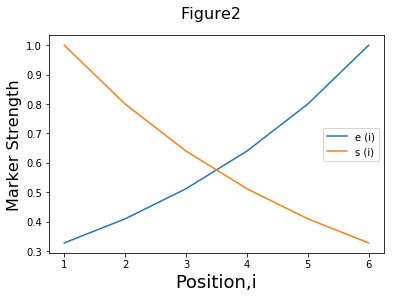

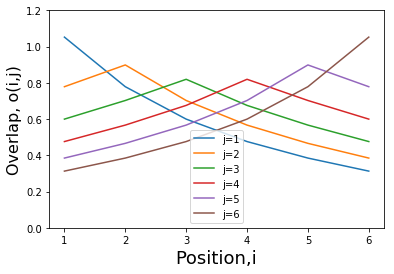

In [32]:
import matplotlib.pyplot as plt
#parameter for Figure2
f2SM = np.zeros(Nitems) #start marker
f2EM = np.zeros(Nitems) #end marker
f2S0 = 1
f2S = 0.8
f2E0 = 1
f2E = 0.8
f2Overlap = np.zeros(Nitems*Nitems).reshape(Nitems,Nitems)
for i in range(Nitems):
    f2SM[i] = f2S0*f2S**(i)
    f2EM[i] = f2E0*f2E**((Nitems-1)-i)
for i in range(Nitems):
    for j in range(Nitems):
        f2Overlap[i][j] = (f2SM[i]*f2SM[j]+f2EM[i]*f2EM[j])**(1/2)*np.exp(-((f2SM[i]-f2SM[j])**(2)+(f2EM[i]-f2EM[j])**(2))**(1/2))


#plot
fig1 = plt.figure(1)
f2EMline = plt.plot(range(1,Nitems+1),f2EM, label="e (i)")
f2SMline = plt.plot(range(1,Nitems+1),f2SM, label="s (i)")
#fig.suptitle('Figure2', fontsize=20)
plt.legend(loc='best')
plt.xlabel('Position,i', fontsize=18)
plt.ylabel('Marker Strength', fontsize=16)

fig2 = plt.figure(2)
for i in range(Nitems):
    plt.plot(range(1,Nitems+1),f2Overlap[i],label="j="+str((i+1)))
axes = plt.gca()
axes.set_ylim([0,1.2])

plt.legend(loc='best')
plt.xlabel('Position,i', fontsize=18)
plt.ylabel('Overlap, o(i,j)', fontsize=16)

fig1.suptitle('Figure2', fontsize=16)

plt.show()

#### 3.3 Fig. 4 
$F=F_0=0.6$

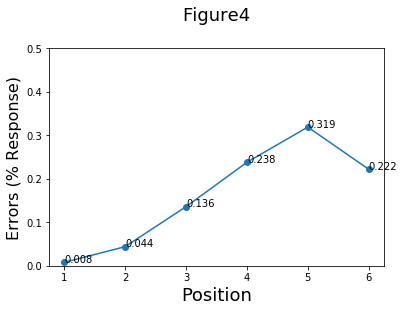

In [34]:
import matplotlib.pyplot as plt

#Figure4-1
error=1-ACC

fig = plt.figure()
plt.plot(range(1,Nitems+1),error,'-o')

axes = plt.gca()
axes.set_ylim([0,0.5])
for a,b in zip(range(1,Nitems+1), error): 
    plt.text(a, b, str(b))
plt.title('Figure4',y=1.1,fontsize=18)
plt.xlabel('Position', fontsize=18)
plt.ylabel('Errors (% Response)', fontsize=16)

plt.show()

#### 3.4 Fig. 5

In [35]:
TG = np.zeros(Nitems*Nitems).reshape(Nitems,Nitems)
def getTG():
    for i in range(NSim):
        for j in range(Nitems):
            if recalls[i][j] == j:
                TG[j][j] += 1
            elif recalls[i][j]!=-1:
                #print(recalls[i][j])
                TG[j][int(recalls[i][j])] +=1
getTG()

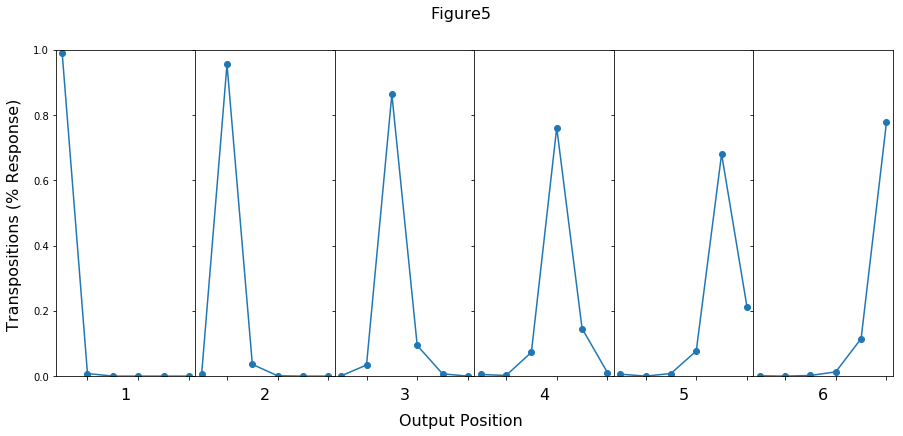

In [37]:
import matplotlib.pyplot as plt
ax = fig.add_subplot(111)
fig, axs = plt.subplots(1,Nitems, figsize=(15, 6), facecolor='w', edgecolor='w')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
fig.suptitle('Figure5', fontsize=16)
fig.text(0.08, 0.5, 'Transpositions (% Response)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 0.01, 'Output Position', ha='center', fontsize=16)

for i in range(Nitems):
    axs[i].plot(range(1,Nitems+1),TG[i]/NSim,'-o')
    axs[i].set_ylim([0,1])
    #axs[i].setxlabel
    axs[i].set_xlabel(str(i+1), fontsize=16)
    axs[i].set_xticklabels([])
    if i !=0 :
        axs[i].set_yticklabels([])

plt.show()

#### 3.5 Fig. 6

In [39]:
listRange = range(1,11)
listCorrect = np.zeros(len(listRange))
recallsList = {}  #store different length recalls
recallsListACC = {}
for j in listRange:
    Nitems = j
    
    SM = np.zeros(Nitems) #start marker
    EM = np.zeros(Nitems) #end marker

    Overlap = np.zeros(Nitems*Nitems).reshape(Nitems,Nitems)
    CompeteResponse = np.zeros(Nitems*Nitems).reshape(Nitems,Nitems)
    recalls = np.zeros(Nitems*NSim).reshape(NSim,Nitems)
    ACC = np.zeros(Nitems)
    outputPosition = np.zeros(Nitems)

    RunSimulation(Nitems)
    getACC(Nitems)

    recallsList[j-listRange[0]] = recalls
    recallsListACC[j-listRange[0]] = ACC

    for i in range(NSim):
        if np.array_equal(recalls[i], np.arange(Nitems)):
            listCorrect[j-listRange[0]]+=1

##### 3.5.1 Fig. 6.1

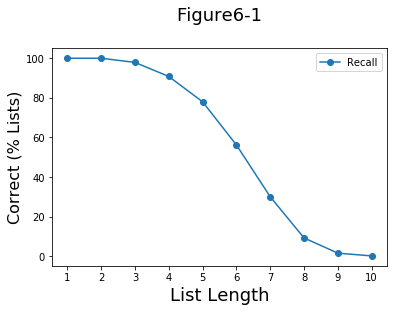

In [48]:
plt.title('Figure6-1',y=1.1,fontsize=18)
plt.plot(range(listRange[0],listRange[-1]+1),listCorrect*100/NSim,'-o',label='Recall')

plt.legend(loc='best')
plt.xlabel('List Length', fontsize=18)
plt.ylabel('Correct (% Lists)', fontsize=16)
plt.xticks(listRange)

plt.show();

##### 3.5.2 Fig. 6.2

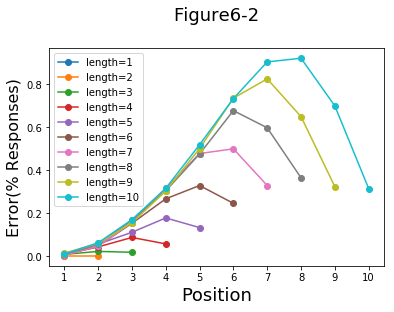

In [45]:
plt.title('Figure6-2',y=1.1,fontsize=18)
for i in listRange:
    plt.plot(range(1,i+1),1-recallsListACC[i-listRange[0]],'-o',label="length="+str((i)))

#axes = plt.gca()
#axes.set_ylim([0,1.2])
plt.xticks(listRange)
plt.legend(loc='best')
plt.xlabel('Position', fontsize=18)
plt.ylabel('Error(% Responses)', fontsize=16)

plt.show()